In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import count

In [2]:
data_initial = pd.read_csv('./titanic/train.csv')

In [3]:
data_initial.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
78,79,1,2,"Caldwell, Master. Alden Gates",male,0.83,0,2,248738,29.0000,NaN,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.00,3,2,19950,263.0000,C23 C25 C27,S
855,856,1,3,"Aks, Mrs. Sam (Leah Rosen)",female,18.00,0,1,392091,9.3500,NaN,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.00,0,0,17463,51.8625,E46,S
454,455,0,3,"Peduzzi, Mr. Joseph",male,NaN,0,0,A/5 2817,8.0500,NaN,S


Для кластеризації має сенс використовувати лише числові колонки, оскільки поняття дистанції між сусідніми значеннями має сенс

In [4]:
data_cluster = data_initial.loc[:, ["Age", "Fare"]]
data_cluster.sample(5)

,Age,Fare
885,39.0,29.125
626,57.0,12.350
476,34.0,21.000
850,4.0,31.275
818,43.0,6.450


In [5]:
data_cluster.isna().sum()

Age     177
Fare      0
dtype: int64

Можливо викинути частину даних з невизначеним віком

In [6]:
data_cluster.dropna(axis=0, inplace=True)
data_cluster.isna().sum()

Age     0
Fare    0
dtype: int64

In [7]:
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation, OPTICS, MeanShift

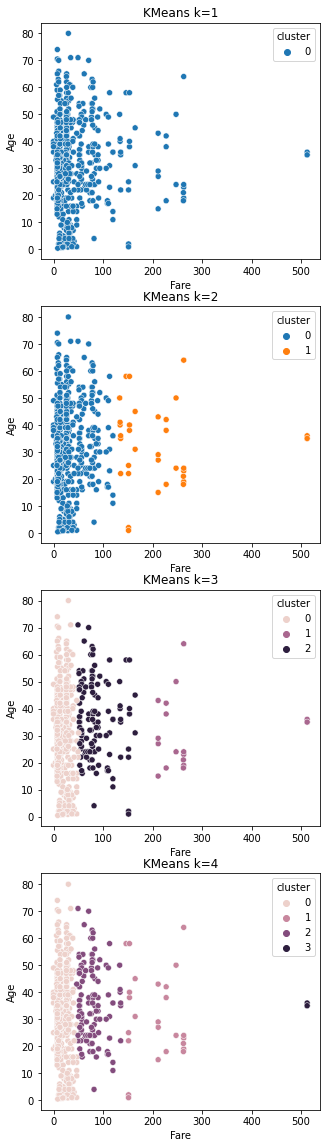

In [8]:
fig, axes = plt.subplots(4, 1)
fig.set_size_inches(5, 20)

for i, k in zip(count(0), (1, 2, 3, 4)):
    data_cluster["cluster"] = KMeans(n_clusters=k, random_state=1).fit_predict(data_cluster)
    sns.scatterplot(data=data_cluster, x="Fare", y="Age", hue="cluster", ax=axes[i])
    axes[i].set_title(f"KMeans k={k}")

plt.show()

Можна бачити, що кластеризація відбувається майже виключно за ціною квитка

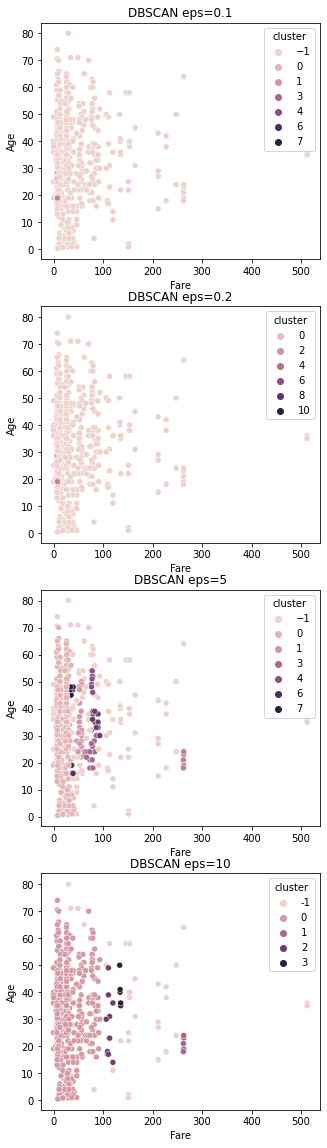

In [9]:
fig, axes = plt.subplots(4, 1)
fig.set_size_inches(5, 20)

for i, eps in zip(count(0), (0.1, 0.2, 5, 10)):
    data_cluster["cluster"] = DBSCAN(eps=eps).fit_predict(data_cluster)
    sns.scatterplot(data=data_cluster, x="Fare", y="Age", hue="cluster", ax=axes[i])
    axes[i].set_title(f"DBSCAN eps={eps}")

plt.show()

Можна бачити, що DBSCAN і KMeans перенавчаються на ціні квитка. Спробуємо звести усі значення до одного розподілу

In [10]:
from sklearn.preprocessing import StandardScaler

data_scaled = data_cluster.drop(columns="cluster")
data_scaled["Age"] = StandardScaler().fit_transform(np.asarray(data_scaled["Age"]).reshape((-1, 1)))
data_scaled["Fare"] = StandardScaler().fit_transform(np.asarray(data_scaled["Fare"]).reshape((-1, 1)))
data_scaled.describe()

,Age,Fare
count,7.140000e+02,7.140000e+02
mean,2.338621e-16,-5.970947e-17
std,1.000701e+00,1.000701e+00
min,-2.016979e+00,-6.560759e-01
25%,-6.595416e-01,-5.038498e-01
50%,-1.170488e-01,-3.583992e-01
75%,5.718310e-01,-2.495211e-02
max,3.465126e+00,9.032109e+00


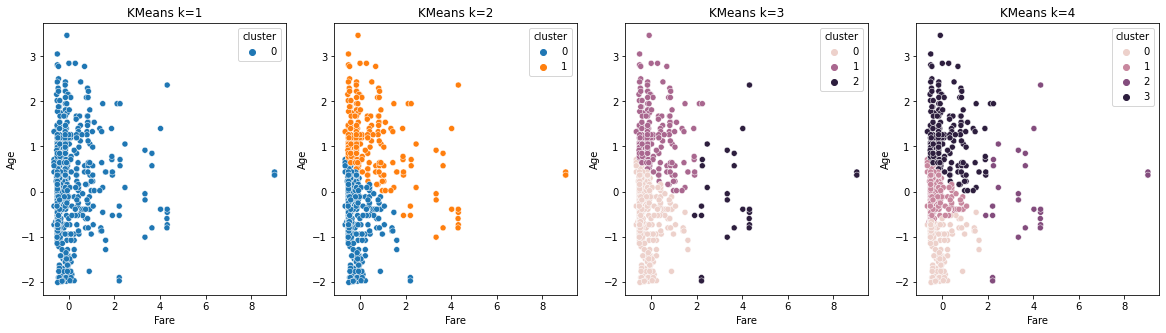

In [11]:
fig, axes = plt.subplots(1, 4)
fig.set_size_inches(20, 5)

for i, k in zip(count(0), (1, 2, 3, 4)):
    data_scaled["cluster"] = KMeans(n_clusters=k, random_state=1).fit_predict(data_scaled)
    sns.scatterplot(data=data_scaled, x="Fare", y="Age", hue="cluster", ax=axes[i])
    axes[i].set_title(f"KMeans k={k}")

plt.show()

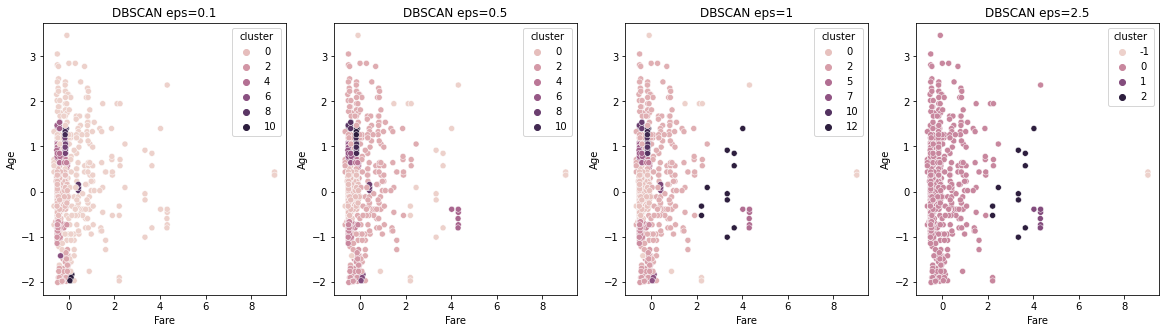

In [12]:
fig, axes = plt.subplots(1, 4)
fig.set_size_inches(20, 5)

for i, eps in zip(count(0), (0.1, 0.5, 1, 2.5)):
    data_scaled["cluster"] = DBSCAN(eps=eps).fit_predict(data_scaled)
    sns.scatterplot(data=data_scaled, x="Fare", y="Age", hue="cluster", ax=axes[i])
    axes[i].set_title(f"DBSCAN eps={eps}")

plt.show()

Найбільший сенс має розділення на 3 кластери з кількома аутлаерами

Спробуємо інші алгоритми кластеризації

c:\users\liza\appdata\local\programs\python\python39\lib\site-packages\sklearn\cluster\_affinity_propagation.py:148: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(


<AxesSubplot:xlabel='Fare', ylabel='Age'>

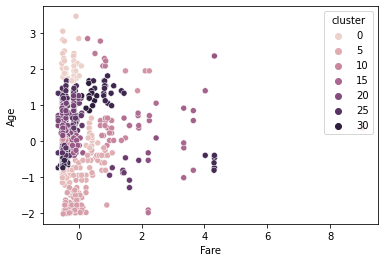

In [13]:
data_scaled["cluster"] = AffinityPropagation(damping=0.7).fit_predict(data_scaled)
sns.scatterplot(data=data_scaled, x="Fare", y="Age", hue="cluster")

Експериментально було визначено, що параметр damping бажано вибирати > 0.7 для даного датасету. Тоді AffinityPropagation буде сходитисьm

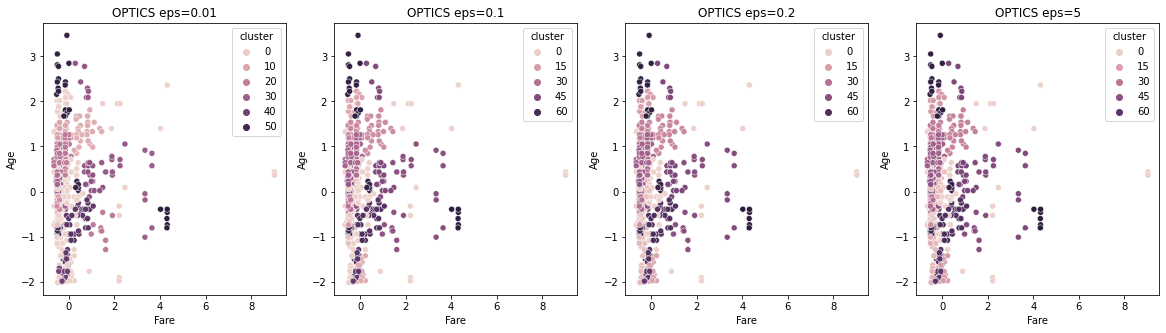

In [14]:
fig, axes = plt.subplots(1, 4)
fig.set_size_inches(20, 5)

for i, eps in zip(count(0), (0.01, 0.1, 0.2, 5)):
    data_scaled["cluster"] = OPTICS(eps=eps).fit_predict(data_scaled)
    sns.scatterplot(data=data_scaled, x="Fare", y="Age", hue="cluster", ax=axes[i])
    axes[i].set_title(f"OPTICS eps={eps}")

plt.show()

OPTICS для різних значень епсилон дає дуже багато маленьких кластерів.

<AxesSubplot:xlabel='Fare', ylabel='Age'>

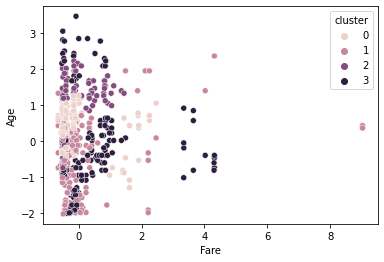

In [15]:
data_scaled["cluster"] = MeanShift().fit_predict(data_scaled)
sns.scatterplot(data=data_scaled, x="Fare", y="Age", hue="cluster", alpha=1)

MeanShift знаходить скупчення точок у розподілі, але, оскільки візуально у нас є доволі рівномірний розподіл основної частини даних, кластери виходять змішані один з одним

Загалом, найкращий результат показав алгоритм DBSCAN, який визначив 3 кластери та виділив деякі елементи як аутлаери

Без зведення значень колонок до схожих розподілів через StandartScaler, алгоритм KMeans дуже сильно оверфітився на значення ціни білету і розділяв дані виключно за колонкою ціни

Результати виконання інших алгоритмів давали дуже багато кластерів, які не мають практичного сенсу для даної задачі